<h1 style="font-family: Georgia; font-size:3em;color:#2462C0; font-style:bold">
Lending Club : Charge Off Probability Estimating </h1><br><h2 style="font-family: Georgia; font-size:1.5em;color:purple; font-style:bold">Shreya Vontela - Masters in Financial Engineering at UC Berkeley </h2><br>


<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Methodology</h2><br>

    1) Handling Missing and NaN Values
    2) Exploratory Data Analysis 
    3) Feature Engineering 
        a) Selected the Correlated features 
        b) Changed formatting 
        c) Created categorical variables
    4) Model Development 
        a) Logistic Regression : Tuned with GridSearch CV and stratified k-fold Sampling
        b) XGBoost : Class Weighted model with Calibration 
    5) Evaluation models and chosing the right one : Recall , Log Loss and Reliability curve
    6) Conclusion on features effecting high charge off rate.



In [1]:
from functions import * 

In [2]:
#imports
from functions import * 

df = pd.read_csv("lc_loan.csv", low_memory=False)
usa = pd.read_csv("us-state-codes.csv")

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Handling missing Values : </h2><br>

- Firstly I am removing the columns which have more than 50% Nan Values
- Then I am looking at the remaining columns and replacing the nan values with 0 for numerical Datatypes and 'missing' for Object Datatypes

In [3]:
#Drop the columns with high nan values 
none_pct = df.apply(lambda x: sum(x.isnull()))/df.shape[0]
high_nan_cols = none_pct[none_pct > 0.5].index
df = df.drop(high_nan_cols, axis=1)


In [4]:
print(f"\033[1m\033[94m Columns with more than 51% Nan Values:\n{40 * '-'}")
print(f"\033[30m{high_nan_cols}\n")

 Columns with more than 51% Nan Values:
----------------------------------------
Index(['desc', 'mths_since_last_delinq', 'mths_since_last_record',
       'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint',
       'verification_status_joint', 'open_acc_6m', 'open_il_6m', 'open_il_12m',
       'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util',
       'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi',
       'total_cu_tl', 'inq_last_12m'],
      dtype='object')



In [5]:
none_pct = df.apply(lambda x: sum(x.isnull()))/df.shape[0] 
col_with_nans = none_pct[none_pct > 0].index

for i in col_with_nans:
    if df[i].dtype == 'O': #If it i an object 
        df[i].fillna('missing',inplace=True)
    else:
        df[i].fillna(0,inplace=True)

## <span style="color:#2462C0"> Adding Charge Off as a Categorical Feature
- Here I am creating a feature named charge off and classifying the loan status into other features

In [6]:
#Creating a new column 
df['charge_off'] = np.where((df.loan_status == 'Charged Off') |
                               (df.loan_status == 'Does not meet the credit policy. Status:Charged Off'), 1, 0 )
df['year'] = pd.to_datetime(df['issue_d']).dt.year
df['month'] = pd.to_datetime(df['issue_d']).dt.month

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Exploratory Data Analysis : </h2><br>

## <span style="color:#2462C0"> Fraction of Charged Off loans
- Imbalance Data : The Charged Off loans are only 5% of the entire loan portfolio

 Imbalance Data : Fraction of Charged Off Loans :0.0547


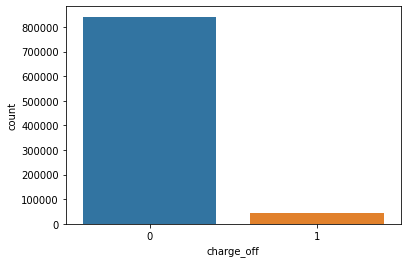

In [7]:
sns.countplot('charge_off', data = df)
print(f"\033[1m\033[94m Imbalance Data : Fraction of Charged Off Loans :{round(len(df[df.charge_off == 1])/len(df[df.charge_off == 0]),4)}")

## <span style="color:#2462C0"> Proportion of Charge Offs and Interest rates over Time
- The highest number of charge offs so far occured are in 2013 and 2014, they have gradually increased over time and then they fell a lot in 2015 
    
- This compares correctly with the increase in Average interest rates of the loans. The average interest rates have been steadily growing over time and the Charged off loans have a always have a higher interest rates. This means the customers with higher interest rates are more likely to default and undergo charge off 

In [8]:
df_charge_off, new_df, rec_df ,df_non_charge_off = create_new_df(df)

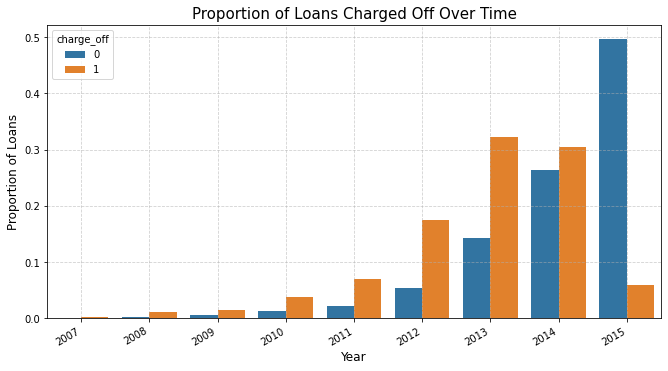

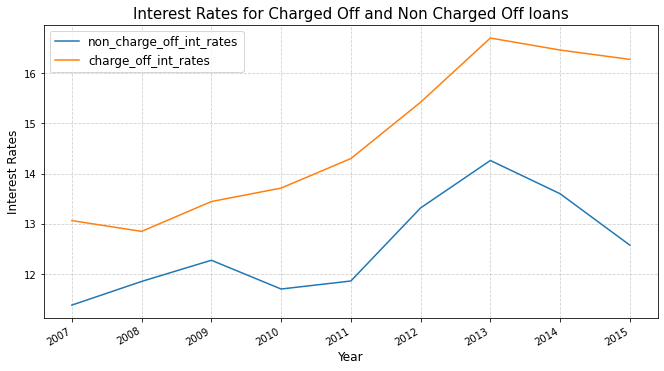

In [9]:
plot_ir(df, df_charge_off, new_df,rec_df ,df_non_charge_off )

## <span style="color:#2462C0"> Total Payments 
- Total Payment seems to be a very good indicator of Charge off because 

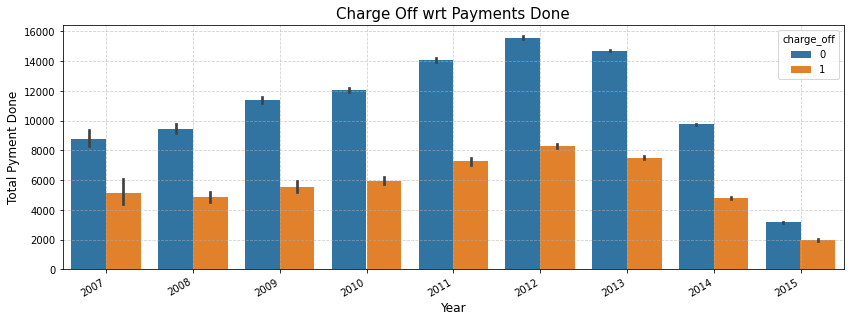

In [10]:
plot_tot_pay(df, df_charge_off, new_df,rec_df ,df_non_charge_off )

## <span style="color:#2462C0"> Recoveries
    
- Firstly we have defined the total recoveries to be the recovered amount and the recovery fees collected by Lending Club. 
- Now we are looking at the percentage of loans charged off and recovered in each year. We see that the charged off loans increased a lot during 2013-15 but the recoveries also increase during this period so thats good. 
    
- Here we can see that the percentage of loans recovered after charge off has steadily been increasing over time and shot up a lot in 2015. It used tb around 2% but increased to 9% in 2015 

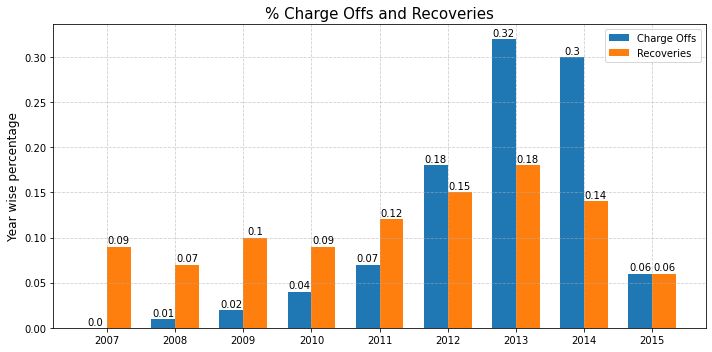

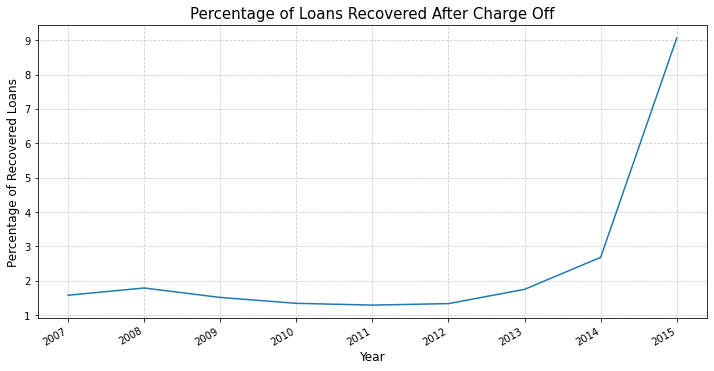

In [119]:
plot_rec(df, df_charge_off, new_df,rec_df ,df_non_charge_off )

## <span style="color:#2462C0"> Recovery Adjusted Charge Off Loss 
    
- Although the recoveries have been increasing in number, the dollar value of recoveries is less as compared to the dollar value of charge offs. 
- As a result we see that the charge off Loss has grown steadily over time 

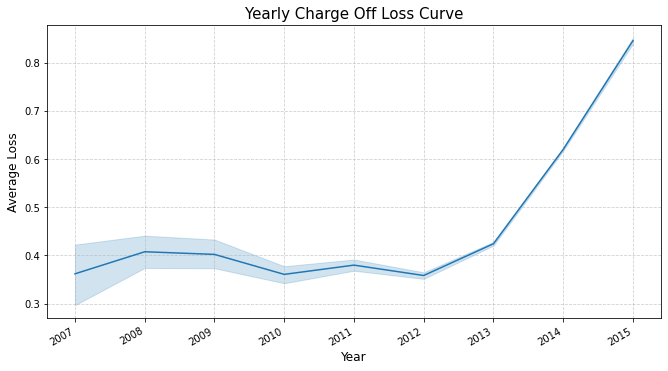

In [12]:
plot_loss(df, df_charge_off, new_df,rec_df ,df_non_charge_off )

## <span style="color:#2462C0"> Cumulative Charg Off Loss
    
- We can see that the cumulative charge off loss is increasing over time and the recoveries are also increasing. The benefit caused due to recoveries is also inc


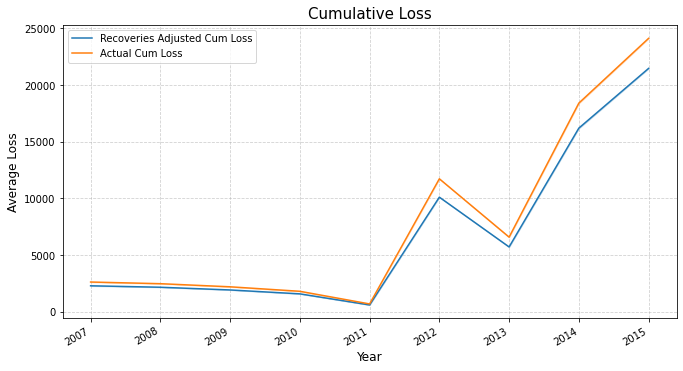

In [13]:
plot_cum_loss(df, df_charge_off, new_df,rec_df ,df_non_charge_off )

## <span style="color:#2462C0"> Why exclude Recoveries from the model ? 
- Recoveries usually occur after the loan has been charged off and here we can see that the positive recoveries only occur when the loan is charged off. So this can act as a perfect predictor of charge off loans. 
- But recoveries come after charge off so we need to exclude these values from the model to avoid data leakage. 

In [120]:
rec_df

,Charged_off,Non_Charged_off
Recoveries = 0,21332,841370
Recoveries > 0,24677,0


## <span style="color:#2462C0"> Number of charge offs and charge off loss wrt Grade
    
- This shows that people belonging to all grades have incurred the same amount of losses in terms of value but the number of charge offs are higher for C and D grade borrowers. 

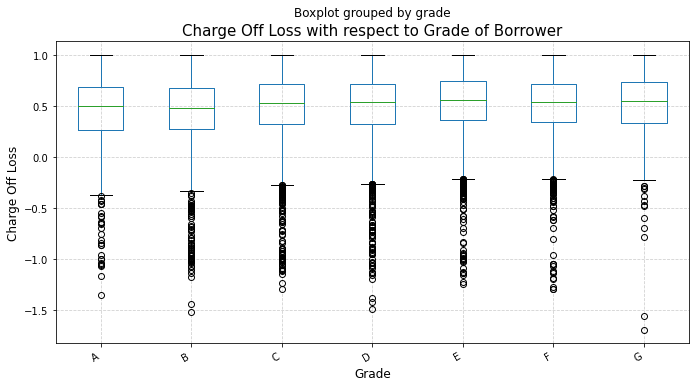

In [14]:
plot_grade(df, df_charge_off, new_df,rec_df ,df_non_charge_off )

## <span style="color:#2462C0"> Recovery Adjusted Charge Off Loss wrt Term of Loan 
- Historically 36 months loans have defaulted more compared to the 60 month loans. But the average loss of 60 months loans is slightly higher in recent times

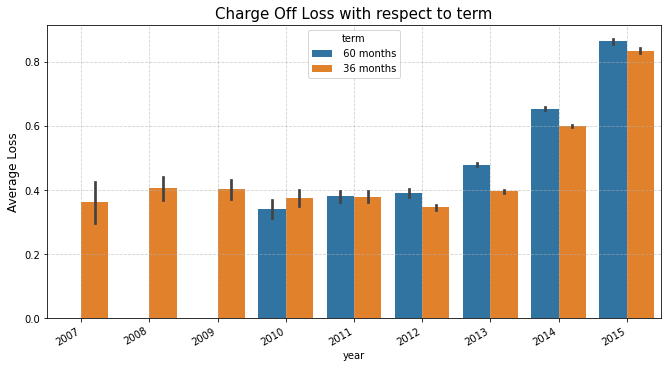

In [15]:
plot_term(df, df_charge_off, new_df,rec_df ,df_non_charge_off )

## <span style="color:#2462C0"> Charge Off wrt Income Level and Purpose of Loan
- We see that lower income people have defaulted more over th

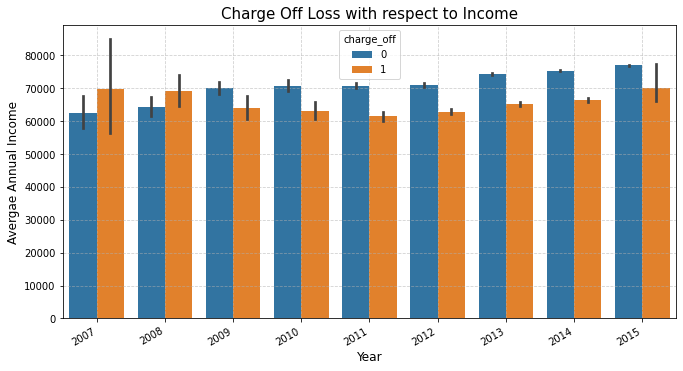

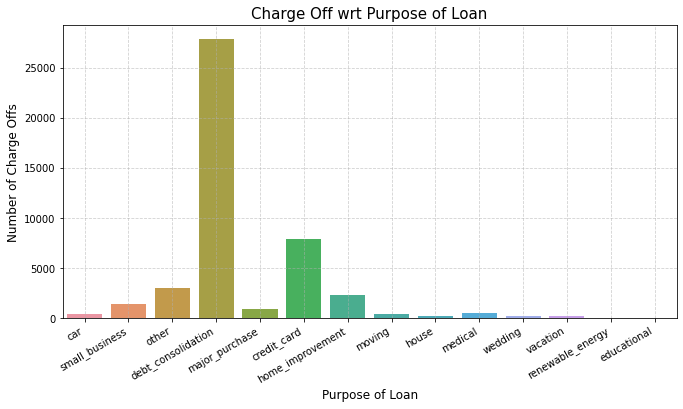

In [17]:
plot_purpose(df, df_charge_off, new_df,rec_df ,df_non_charge_off )

## <span style="color:#2462C0"> Charge Off wrt Revolving Utilization, Revolving Balance , Total Collateral Amount and Total Balance 

- We see from the plots that the charge off is high for loans with higher revolving utilization , lower collateral and lower total balance. 
- Revolving balance is in general low for charged off loans but it shows a skewed trend in 2007-2009 but again the standard deviation is high there 


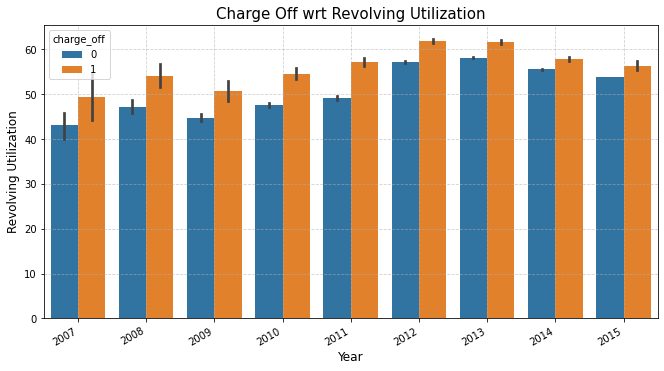

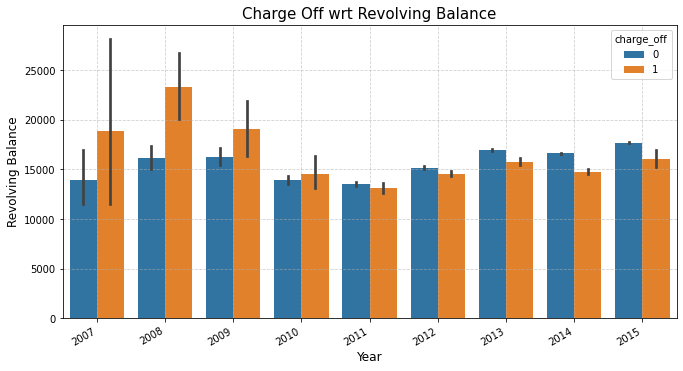

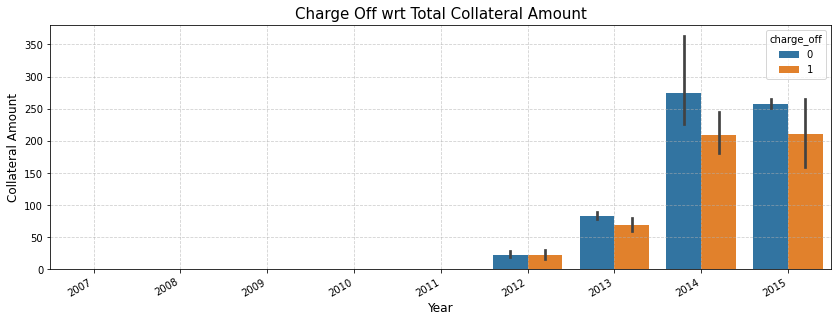

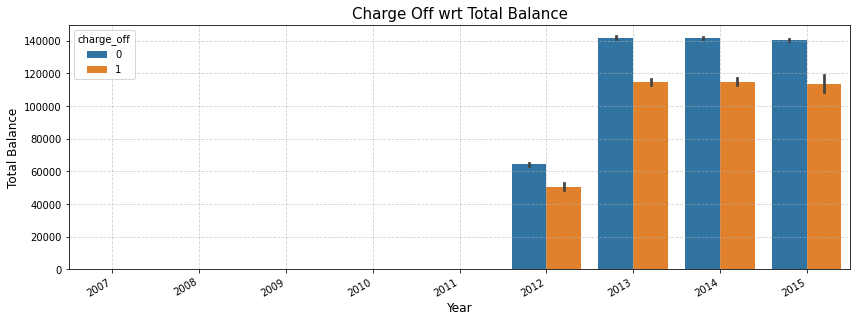

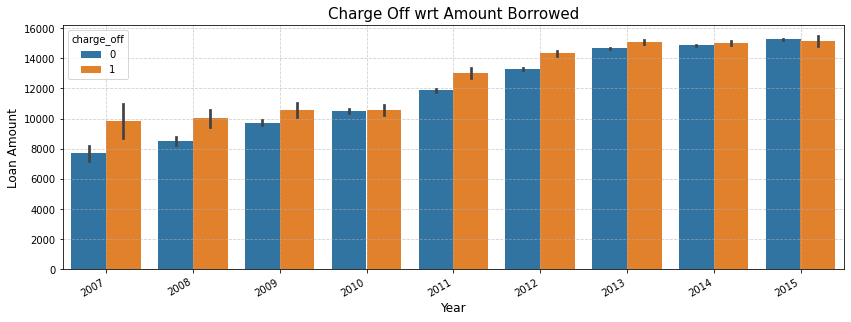

In [18]:
plot_revol(df, df_charge_off, new_df,rec_df ,df_non_charge_off )

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Feature Engineering</h2><br>


## <span style="color:#2462C0"> Formatting the columns 

In [47]:
df['term'] = np.where(df['term'] ==' 36 months', 36, 60 )
df_test['term'] = np.where(df_test['term'] =='36 months', 36, 60 )

for col in ['inq_last_6mths','delinq_2yrs','acc_now_delinq']:
    df[col] = df[col].astype('float')
    df_test[col] = df_test[col].astype('float')

    df[col] = np.where(df[col] > 1.0, 2, df[col])
    df_test[col] = np.where(df_test[col] > 1.0, 2, df_test[col])
    
df['emp_length'] = np.where(df['emp_length'] == '< 1 year', '<1 year', df['emp_length'] )
df['emp_length'] = df['emp_length'].str.split(" ").str.get(0)

df_test['emp_length'] = np.where(df_test['emp_length'] == '< 1 year', '<1 year', df_test['emp_length'] )
df_test['emp_length'] = df_test['emp_length'].str.split(" ").str.get(0)

df.emp_length = np.where(df.emp_length == '<1', '0',df.emp_length)
df_test.emp_length = np.where(df_test.emp_length == '<1', '0',df_test.emp_length)

df.emp_length = df.emp_length.fillna('0')
df_test.emp_length = df.emp_length.fillna('0')

## <span style="color:#2462C0"> Predictors Selection 

In [49]:
all_cols

['int_rate',
 'revol_util',
 'loan_amnt',
 'dti',
 'total_pymnt',
 'installment',
 'annual_inc',
 'revol_util',
 'revol_bal',
 'tot_coll_amt',
 'tot_cur_bal',
 'term',
 'grade',
 'emp_length',
 'home_ownership',
 'acc_now_delinq',
 'inq_last_6mths',
 'delinq_2yrs']

## <span style="color:#2462C0"> Created Categorical Variables 

In [51]:
req_cat_cols 

['term',
 'grade',
 'emp_length',
 'home_ownership',
 'acc_now_delinq',
 'inq_last_6mths',
 'delinq_2yrs']

In [ ]:
df = dummy_df(df, req_cat_cols)

## <span style="color:#2462C0">Train and Test Split

In [ ]:
X_features = list(df.columns.values)
X_features.remove('charge_off')
X_train = df[X_features]
y_train = df['charge_off']

X_test = df_test[X_features]
y_test = df_test['charge_off']

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Model Development</h2><br>

## <span style="color:purple"> Logistic Regression
    
- It inherently **predicts the log odds** so this is a direct choice to estimate the probability of chargeoff
- Some classifiers like SVM are descriminative classifiers, which just say if the given data point is in class 1 or class 2 but do not give any informmation of the probability of being in that class. 
- This is important for us because we would like to know the likelihood of the person defaulting, so that we can estimate the risk exposure of the loan portfolio. 
- So we need **Non discriminative classifiers**

    
## <span style="color:#2462C0"> Parameters 
- Performed Hyper parameter tuning using **Grid Search CV** for regularisation constant C and used a **elastic net** regulatization method. 
- In Grid Search CV, I used the **scoring parameter as negative log loss** because the objective here is to predict the probabilities better. This will try to push the probabilities more towards the actual values. 
- Inside GridSearch CV, I am using **Stratified K fold sampling** to help reduce the variance in cross validation. 
- The threshold I used is 0.05, which is the ratio of total positives in the data. This is not very important because we are more focused on the log loss. 

## <span style="color:#2462C0"> Results 
- ROC is 0.53 so **classifier is almost random** 
- Log loss score and brier score are decent but model lacks predictive performance. 
- This is possible because of the highly imbalanced dataset (5% of Charge off loans)
- For this problem **recall is the next most important factor after the probabiities because it measures the correct number of defaulters we predicted.** Its more dangerous to wrongly accept a bad customer (FN is important)'


In [54]:
logistic = read_pickle('logistic.p')
res = pd.read_csv('logistic_results.csv')
del res['Unnamed: 0']

In [82]:
logistic

LogisticRegression(C=0.30000000000000004, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=0.5,
                   max_iter=100, multi_class='auto', n_jobs=-1,
                   penalty='elasticnet', random_state=None, solver='saga',
                   tol=0.0001, verbose=0, warm_start=False)

In [83]:
results = pd.DataFrame(res.mean(axis = 0 ), columns = ['Logistic Regression'], 
                       index = ['log_score', 'brier_score','recall','precision','f1score','roc_auc','accuracy'])
results

,Logistic Regression
log_score,0.230750
brier_score,0.051323
recall,0.560717
precision,0.056110
f1score,0.102012
roc_auc,0.537428
accuracy,0.516420


## <span style="color:#2462C0"> ROC AUC Curve
- Looks similar to a random classfier

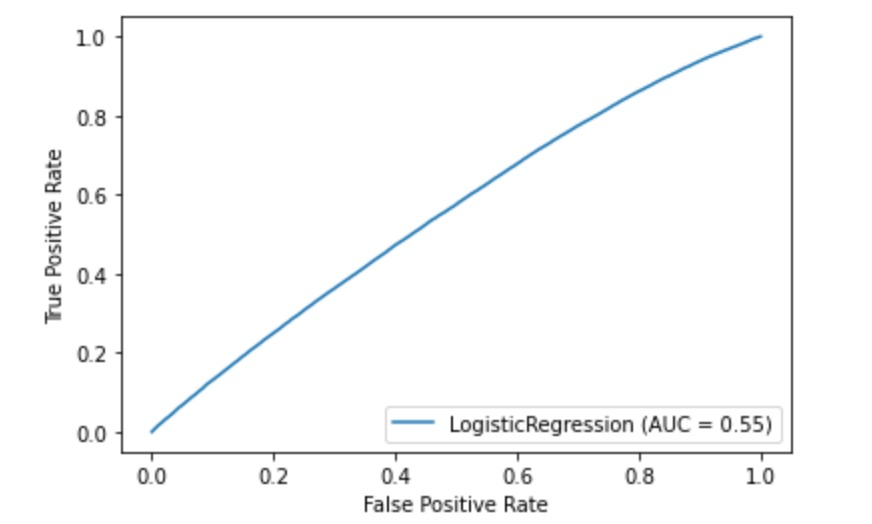

In [98]:
l = read_pickle('logistic_roc_auc.p')
Image(filename='log.jpeg', width = 600, height = 300)

## <span style="color:purple">XG Boost Classifier
    
- Next I have used a XGBoost model which in general is a good classifier for non linear boundaries and also supports categorical data. 
- Here I am training the XGB model with **binary logistic loss** so this also gives us an estimate of the prob of charge off 
- For this model I tuned the hyperparamters using **Grid search cv with stratified sampling**. The parameters I used were : max_depth , min_child_weight, gamma and n_estimators
    
    
## <span style="color:#2462C0"> Results 
- The **log score and brier score** have reduced significantly
- We observed that the ROC , precision and recall improved for the XGBoost model. 
- Recall is good but precision and F1score are bad and this is due to the class imbalance. 
- So even here the reliability curve is not nice, the **probabiliies are still not calibrated.**

In [85]:
xgb_res = pd.read_csv('xgb_original.csv')
del xgb_res['Unnamed: 0']
results['XGBoost Classifier'] = xgb_res.mean(axis =0 )
results

,Logistic Regression,XGBoost Classifier
log_score,0.230750,0.187393
brier_score,0.051323,0.046779
recall,0.560717,0.603132
precision,0.056110,0.093583
f1score,0.102012,0.162022
roc_auc,0.537428,0.651074
accuracy,0.516420,0.694319


## <span style="color:#2462C0"> ROC AUC Curve

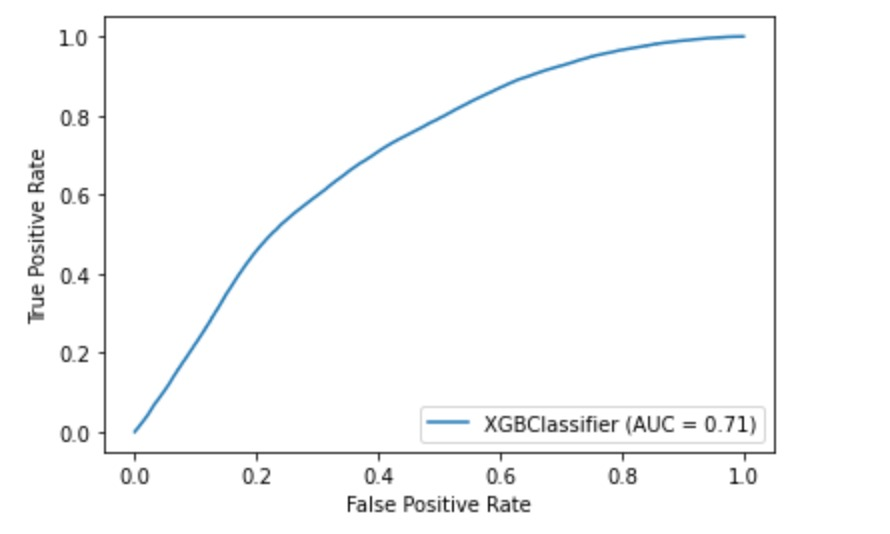

In [113]:
Image(filename='xgb_normal.jpeg', width = 600, height = 300)

## <span style="color:#2462C0"> Feature Importance  

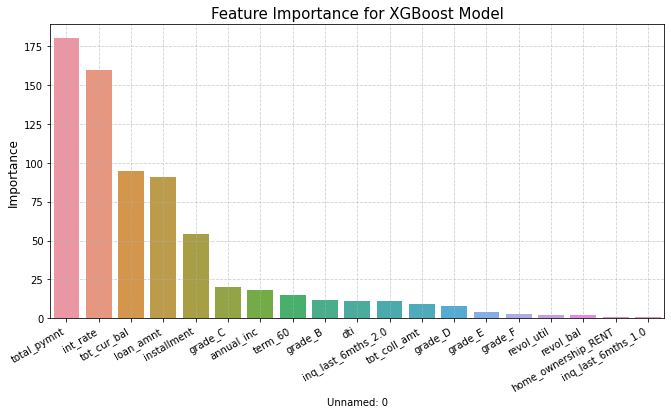

In [121]:
feat_imp = pd.read_csv('feature_imp.csv')
feat_imp.index= feat_imp['Unnamed: 0']
plt.figure(figsize=(11,6))
sns.barplot('Unnamed: 0','0',data=feat_imp)
plt.ylabel('Importance',fontsize = 12)
plt.title('Feature Importance for XGBoost Model',fontsize = 15)

plt.gcf().autofmt_xdate()
plt.grid(alpha =.6, linestyle ='--') 
plt.show()

## <span style="color:#2462C0"> Relliability Curve 
- Since we are predicting the probabilities , the logistic regression and XGBoost were the 2 main choices for us because they use logistic loss. However it might still be possible that the predicted quantity maynot be representative of the likelihood of loan charge off. This is ususally studied using reliability curves. 
- Assume we have 100 points and x axis is from 0-1 and we take 10bins each with distance 0.1. In a reliability curve we put all teh points in that bin depending on the probabilities predicted for that point 
- For instance the bin between 0.2 and 0.3 contains all the points in the test set for which our model predicted a probability between 0.2 and 0.3. 
- The y axis correspondins to the actual fraction of these points which are indeed charged off loans
- Overall, a good claibrated model should ideally be a straight line with slope 1. 

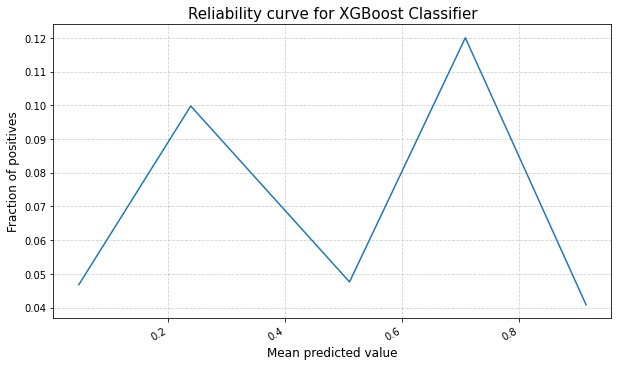

In [122]:
log = read_pickle('new_xgb_reliability.p')
plt.show()

## <span style="color:purple"> Calibrated XG Boost Classifier

- The technique to calibrate the model is called classifier calibration. 
- Here we have the best parameters from the previous grid search. So now from the train data, we do another 10 fold cross validation which is called calibrated classifier CV. 
- Here what we do is we take a train and val split and we will train the model on train data and on the val data we will predict the probabilities. 
- Now we fit a linear model on the validation probabilities to reduce the log loss between the actual val and predicted val. 
- This effectively pushes the calibration curve towards the 45 deg line
- When we are predicting on test data, we use the XGM model first then we use the calibrated model on top it, so that we transform the predicted probabilities into a more calibrated form.
    
## <span style="color:#2462C0"> Results
- Even after this we the model dint improve much, this is because of the class imbalance. 
    
## <span style="color:#2462C0"> ROC AUC Curve
- This does not change from before 

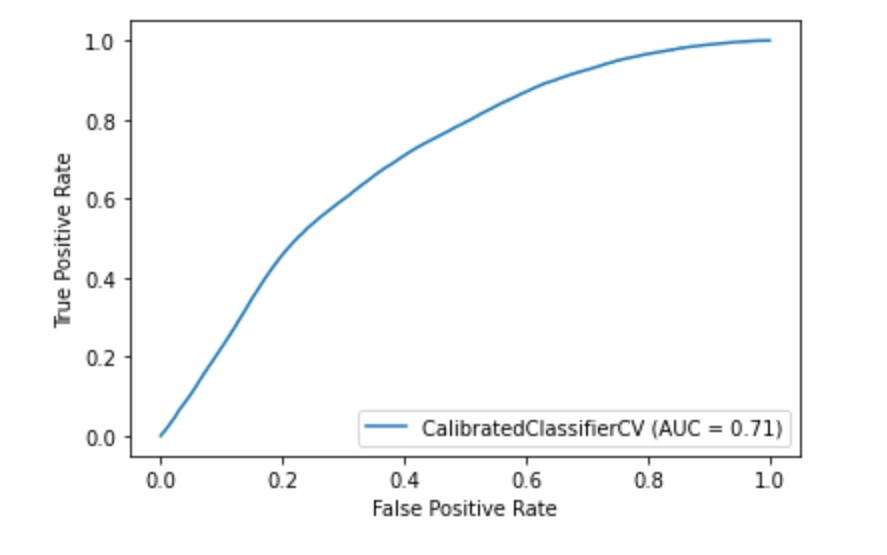

In [99]:
Image(filename='xgb.jpeg', width = 600, height = 300)

## <span style="color:#2462C0"> Reliability Curve

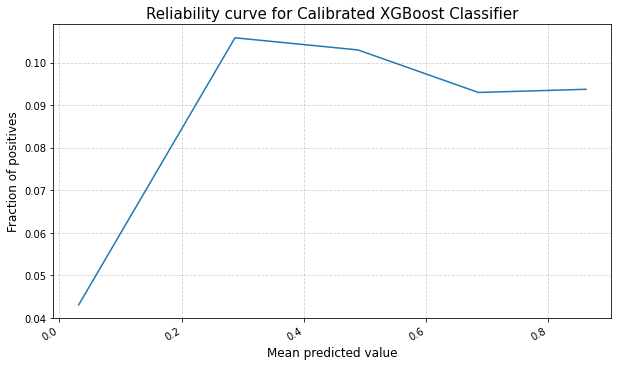

In [116]:
log = read_pickle('new_xgb_sigm_reliability.p') 
plt.show()

## <span style="color:purple"> Class Weighted XG Boost Classifier

- The loss weight of defaulters is more as compared to the loss weight of non defaulters. 
- Did a grid search on scale_pos_weight hyperparameter in the xgboost mdodel and then repeated the calibration process. 
- We observe that the probabilities are much better calibrated in this model
- The preformance metrics remain same but the probabilities are better calibrated 
    
## <span style="color:#2462C0"> Reliability Curve

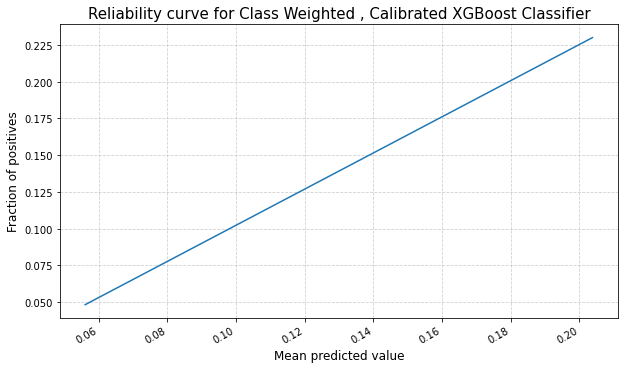

In [117]:
log = read_pickle('new_xgb_weighted_sigm_reliability.p')
plt.show()

# <span style="color:purple"> THE END 

In [ ]:

plt.figure(figsize=(10,6))
plt.plot(log[0][1], log[0][0])
plt.ylabel('Fraction of positives',fontsize = 12)
plt.title('Reliability curve for Calibrated XGBoost Classifier',fontsize = 15)
plt.xlabel('Mean predicted value',fontsize = 12)
plt.gcf().autofmt_xdate()
plt.grid(alpha =.6, linestyle ='--')

In [ ]:

plt.figure(figsize=(10,6))
plt.plot(log[0][1], log[0][0])
plt.ylabel('Fraction of positives',fontsize = 12)
plt.title('Reliability curve for Class Weighted , Calibrated XGBoost Classifier',fontsize = 15)
plt.xlabel('Mean predicted value',fontsize = 12)
plt.gcf().autofmt_xdate()
plt.grid(alpha =.6, linestyle ='--') 

In [ ]:

plt.figure(figsize=(10,6))
plt.plot(log[0][1], log[0][0])
plt.ylabel('Fraction of positives',fontsize = 12)
plt.title('Reliability curve for XGBoost Classifier',fontsize = 15)
plt.xlabel('Mean predicted value',fontsize = 12)
plt.gcf().autofmt_xdate()
plt.grid(alpha =.6, linestyle ='--') 

- This is important because in real world, new customer comes and he was rejected for the loan because D.clf classified the customer as a defaulter but does not tell the likelihood of the person defaulting. 
- So we need to know the probbaility to estimate the risk better. 
- for example P1 and P2, each make loan 100k , 10k . Both of them were rejected by the model. first guy might be defaulting with prob 0.2 (loss = 20k) and 2nd person is 0.8 (loss = 8k). So knowing the likelihood of defaulting will help lending make better decisions. 

In [95]:
from IPython.display import Image
import pickle
def convert_to_pickle(df, loc_with_name): #Convert to a pickle file 
    with open(loc_with_name, 'wb') as fp:
        pickle.dump(df, fp)

def read_pickle(loc_with_name): #Read a pickle file 
    with open (loc_with_name, 'rb') as fp:
        df = pickle.load(fp)
    return df 